In [10]:
print("test")

test


# Demo with mock diet-microbiome data

In [11]:
import pandas as pd
# from LabData.DataLoaders.GutMBLoader import GutMBLoader
# from LabData.DataLoaders.SubjectLoader import SubjectLoader
# from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
# from LabData.DataAnalyses.TenK_Trajectories.utils import get_diet_logging_around_stage
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import lightgbm as lgb
import math
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr
import re

In [12]:
SPECIES = 'segal_species' # 'segal_species' or 'mpa_species'
color1 = "#66C2A5"
single_style = "nature_single.mplstyle"
double_style = "nature_double.mplstyle"
third_style = "nature_third.mplstyle"
plt.rcParams["figure.dpi"] = 150
plt.style.use(single_style)
palette = sns.color_palette("Set2", n_colors=8)

In [13]:
def read_results(df):
    output = []
    for col in df.columns:
        output.append(df[col])
    return tuple(output)

In [14]:
species = '' if SPECIES == 'segal_species' else '_mpa'

with open('my_lists.pkl', 'rb') as file:
    loaded_lists = pickle.load(file)
base_features, all_features, targets = loaded_lists

In [52]:
diet_mb = pd.read_csv("demo_diet_mb.csv")
diet_mb

,Acorn squash,Alfalfa sprouts,Almond Beverage,Almond flour,Almond spread,Almonds,Amba,Apple,Apple Cake,Apple Vinegar,...,fBin__88|gBin__434|sBin__637,fBin__94|gBin__448|sBin__654,fBin__94|gBin__449|sBin__656,fBin__95|gBin__450|sBin__659,fBin__96|gBin__457|sBin__669,fBin__97|gBin__462|sBin__676,fBin__97|gBin__462|sBin__678,fBin__99|gBin__469|sBin__687,Richness,Shannon_diversity
0,0.611799,0.435788,-1.057386,-0.456504,0.393287,-0.049108,1.706516,-1.281797,-0.508547,-0.331064,...,1.146988,1.132406,-0.599611,-0.819340,-0.287950,-0.480077,-1.331591,-0.424640,0.430268,0.345291
1,-0.538789,-0.334307,1.304551,-2.354801,2.342455,0.528055,1.053105,0.236835,-0.740851,0.304000,...,0.750056,-0.047109,-0.675733,0.059897,-1.441072,-0.362023,1.559046,0.119952,0.561480,0.424420
2,-1.964359,-1.708201,-1.564199,-0.279111,-0.497831,0.618759,2.024893,0.410266,-1.424383,-0.729111,...,-1.678563,-0.426127,1.083459,0.662174,0.681321,-1.465943,-0.760938,0.219229,1.879647,-0.844118
3,0.264930,-0.495000,0.183057,-0.620951,0.425951,-0.113100,0.574076,-1.764698,-1.053275,-0.531450,...,0.254559,0.504258,1.405185,-1.118877,0.632067,-0.225690,1.077850,0.507353,-1.024117,-0.447258
4,-0.291676,-0.096020,0.625042,2.433426,-0.539412,-1.197344,-0.686906,0.204008,2.688069,-0.105575,...,-0.576718,-0.502762,-0.707346,0.491387,-0.877552,0.856339,1.587806,-0.356674,-0.029271,-1.954423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.174758,-1.109467,1.168144,0.651951,-1.269537,-0.023732,0.499368,0.951757,0.013598,0.220810,...,0.113656,0.578626,-1.591083,-0.470190,-0.128017,1.446394,-0.742092,-0.300274,1.374601,0.290714
96,0.444786,0.191730,-0.896614,0.246373,1.194276,-2.407358,-0.933603,-0.775462,0.658995,-0.618275,...,-1.087108,0.529822,0.293000,0.165234,-0.112154,-0.012601,-1.716088,-1.964501,1.175795,1.051597
97,-2.343024,-0.003070,1.558069,-0.609231,-0.817920,-0.738585,0.654985,-0.138785,-0.987675,1.145155,...,-0.764373,0.512142,-1.801611,0.040682,0.642443,1.823932,0.171187,1.461368,-0.483361,0.973300
98,-0.556472,-0.414189,0.352758,1.158438,-2.950842,-0.054977,0.354772,-1.021687,1.364005,-3.129082,...,1.222685,0.595895,-0.137555,-0.391741,0.036653,1.429916,-0.994514,0.557929,-0.065779,1.160303


In [16]:
targets_reformatted = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in targets]

In [17]:
len(targets)

724

### Model Training

In [21]:
import math
import os
import re
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 


### PARAMETERS ###
MODEL = 'LGBM' # 'LGBM' or 'ridge' or 'logistic'
TARGETS = 'abundance' # 'div' or 'abundance' or 'diet' or 'health' or 'pathways'
SPLIT = 'kfold' # 'kfold' or 'longitudinal'
PROBLEM = 'regression' # 'regression' or 'classification' or 'reverse' or 'given_presence'
SPECIES = 'segal_species' # 'segal_species' or 'mpa_species'
base_training = False
CLR_flag = False
robust_training = False
ROBUST_REPEATS = 5  # number of subsamples per grid size
no_var_features = False
foods_only = False
##################

suffix = '_longitudinal' if SPLIT == 'longitudinal' else '' 
colsample_bytree = 1 if base_training else 0.3
target_part = 'diet' if PROBLEM == 'reverse' else f'{TARGETS}'
base = 'base_' if base_training else ''
suffix_var = '_no_var_features' if no_var_features else ''
suffix_foods = '_foods_only' if foods_only else ''
pathways = '' if TARGETS != 'pathways' else '_pathways'
CLR_suf = '_CLR' if CLR_flag else ''
# SAVE_MODELS_IN_ROBUSTNESS = False if robust_training else True  # do not pickle models in robustness runs


def stub_subjob(df, features, target, i, models_dict):
    all_scores = []
    all_p_values=[]
    all_feat_importances = []
    # all_feat_names = []
    all_preds = []
    all_targets = []
    models_list = []

    df = df.dropna(subset=[target])

    if PROBLEM == 'given_presence':
        df = df[df[target] > -4].copy()
        prevalence = df[target].shape[0]

    kf = KFold(n_splits=5, shuffle=False) # If shuffle turned on add a random_state=1 kwarg.

    preds = []
    targets = []

    for fold_number, (train_index, test_index) in enumerate(kf.split(df)):
            train = df.iloc[train_index]
            test = df.iloc[test_index]

            if MODEL == 'ridge':
                model = linear_model.RidgeCV(alphas=(0.01, 0.1, 0.5, 1, 10, 100))            
            elif MODEL == 'LGBM':
                if PROBLEM == 'reverse': # Trying hyperparameters modifications, only for reverse for now
                    model = lgb.LGBMRegressor(
                        max_depth=6, n_estimators=2000, subsample=0.5, subsample_freq=1,
                        colsample_bytree=colsample_bytree, learning_rate=0.01, n_jobs=8, random_state=1, 
                        reg_alpha=0, reg_lambda=10, min_data_in_leaf=50, num_leaves=50, verbosity=-1
                    )  
                else:  
                    model = lgb.LGBMRegressor(
                        max_depth=4, n_estimators=2000, subsample=0.5, subsample_freq=1,
                        colsample_bytree=colsample_bytree, learning_rate=0.001, n_jobs=8, random_state=1, 
                        reg_alpha=1, reg_lambda=1, min_data_in_leaf=20, verbosity=-1
                    )

            model.fit(train[features], train[target])
            predictions = model.predict(test[features])
            preds.extend(predictions)
            targets.extend(test[target])
            models_list.append(model)

    models_dict[i] = models_list
    score = stats.pearsonr(preds, targets)
    all_scores.append(score[0])
    all_p_values.append(score[1])

    if MODEL == 'ridge':
        all_feat_importances.append(model.coef_)
        # all_feat_names.append(features)
    if MODEL == 'LGBM':
        all_feat_importances.append(model.feature_importances_)
        # all_feat_names.append(model.feature_name_)

    all_preds.append(preds)
    all_targets.append(targets)

    if PROBLEM != 'given_presence':
        return all_scores, all_p_values, all_feat_importances, all_preds, all_targets
    elif PROBLEM == 'given_presence':
        return all_scores, all_p_values, all_feat_importances, all_preds, all_targets, prevalence

In [25]:
diet_mb.columns = diet_mb.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

features = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in all_features]
original_features = features[:]
features = base_features if base_training else features
target_input = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in targets]

In [45]:
def training_loop(diet_mb, features, target_input):
    params_results = {}
    models_dict = {}
    if TARGETS == 'abundance' or TARGETS == 'pathways' or PROBLEM == 'reverse':
        loop_targets = target_input
    elif TARGETS == 'div':
        loop_targets = ['Richness', 'Shannon_diversity']
    

    with tqdm(total=len(loop_targets), desc="Training Progress", leave=True, dynamic_ncols=True, position=0) as pbar:
        pbar.refresh()
        for i in range(len(loop_targets)):
            params_results[i] = stub_subjob(diet_mb, features, loop_targets[i], i, models_dict)

            pbar.update(1)

    output = pd.DataFrame(params_results).transpose().apply(lambda x: x.explode(), axis=1)
    return output


In [46]:
output = training_loop(diet_mb, features, target_input)
output

Training Progress: 100%|██████████| 724/724 [30:38<00:00,  2.54s/it]


,0,1,2,3,4
0,-0.171440,0.088102,"[2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 3, 1, 0, 0, ...","[-0.0013374969154257817, 0.08274360679268514, ...","[-1.1972094222539726, -0.7647815045483872, -0...."
1,-0.023613,0.815608,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 4, 0, 0, ...","[0.0659530628036398, 0.1473453084626831, 0.099...","[1.6225252938005683, -1.4239638817688298, 0.79..."
2,-0.163159,0.104811,"[1, 0, 0, 0, 16, 0, 2, 0, 0, 1, 1, 11, 0, 0, 0...","[0.044665475565784096, 0.12313235880286089, 0....","[0.6187734979258739, -1.6446289580650602, 0.86..."
3,-0.173042,0.085127,"[0, 1, 0, 7, 0, 0, 0, 1, 0, 0, 2, 1, 2, 15, 0,...","[0.02553820398528761, 0.04771519930847066, -0....","[-0.6355488838700889, -0.2084681232026771, 0.9..."
4,-0.041215,0.683907,"[3, 1, 0, 0, 2, 1, 2, 0, 0, 4, 14, 0, 4, 0, 0,...","[0.23753121908011007, 0.13832163252546498, 0.2...","[0.0263153124907176, -1.2457514583398746, -0.6..."
...,...,...,...,...,...
719,-0.265633,0.007560,"[0, 0, 3, 0, 0, 0, 0, 3, 5, 0, 0, 0, 1, 3, 0, ...","[0.12818463273084987, 0.17971213588097806, 0.1...","[-0.8193404353601007, 0.0598970567467621, 0.66..."
720,-0.227677,0.022718,"[1, 1, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, ...","[-0.09584016102722111, -0.09429828475578027, -...","[-0.2879500452233222, -1.4410724350307234, 0.6..."
721,-0.265611,0.007566,"[0, 1, 0, 9, 0, 16, 1, 0, 2, 0, 0, 1, 0, 1, 0,...","[0.20001258696396998, 0.11028306317897295, 0.2...","[-0.4800767829884833, -0.3620232048835384, -1...."
722,-0.313925,0.001470,"[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.10850020041380407, -0.04307964728764181, -...","[-1.3315914386969825, 1.5590463245297606, -0.7..."


## Microbes Targets

### Age and Gender

In [47]:
# # lgbm_base_scores, lgbm_base_pvalues, lgbm_base_coefs, lgbm_base_fnames = train_test(diet_mb, base_features, targets, "lgbm")
# lgbm_base_scores, lgbm_base_pvalues, lgbm_base_coefs, lgbm_base_preds, lgbm_base_targets = read_results(output)
# lgbm_base_scores

### Diet

In [48]:
lgbm_diet_scores, lgbm_diet_pvalues, lgbm_diet_coefs, lgbm_diet_preds, lgbm_diet_targets = read_results(output)
print(lgbm_diet_scores)

0     -0.171440
1     -0.023613
2     -0.163159
3     -0.173042
4     -0.041215
         ...   
719   -0.265633
720   -0.227677
721   -0.265611
722   -0.313925
723   -0.164222
Name: 0, Length: 724, dtype: float64


In [49]:
lgbm_diet_scores = pd.Series(lgbm_diet_scores)
lgbm_diet_scores.describe()

count    724.000000
mean      -0.143226
std        0.124868
min       -0.437467
25%       -0.230040
50%       -0.156840
75%       -0.062144
max        0.281246
Name: 0, dtype: float64

### Choose Significant Targets without permutations

In [50]:
# How many predictions were statistically significant?
signifancts = lgbm_diet_pvalues[lgbm_diet_pvalues < 0.05].shape[0]
print("{} significant predictions ({}%)".format(signifancts, round((signifancts/len(lgbm_diet_pvalues))*100), 2))

lgbm_diet_pvalues_adj = multipletests(lgbm_diet_pvalues, method='fdr_bh', alpha=0.05)[1]
lgbm_diet_pvalues_adj = pd.Series(lgbm_diet_pvalues_adj)

# How many predictions were statistically significant after adjustment?
FDR_threshold = 0.05
significants_adj = lgbm_diet_pvalues_adj[lgbm_diet_pvalues_adj < FDR_threshold].shape[0]
print("{} significant predictions ({}%) after adjustment.".format(significants_adj, round((significants_adj/len(lgbm_diet_pvalues))*100), 2))

significant_targets = [target for target, p_adj in zip(targets, lgbm_diet_pvalues_adj) if p_adj < FDR_threshold]
print(targets)
print(len(targets))
print(significant_targets)
print(len(significant_targets))

significant_targets_index = [index for index, (target, p_adj) in enumerate(zip(targets, lgbm_diet_pvalues_adj)) if p_adj < FDR_threshold]
print(targets)
print(significant_targets_index)

matched_data = pd.DataFrame({'scores': lgbm_diet_scores, 'pvalues_adj': lgbm_diet_pvalues_adj}).dropna()
non_significant_scores = matched_data.loc[matched_data['pvalues_adj'] >= FDR_threshold, 'scores']
percentile_99 = np.percentile(non_significant_scores, 99)
print("99th percentile of non-significant scores:", percentile_99)

264 significant predictions (36%)
120 significant predictions (17%) after adjustment.
['fBin__100|gBin__473|sBin__693', 'fBin__100|gBin__473|sBin__694', 'fBin__100|gBin__474|sBin__695', 'fBin__100|gBin__477|sBin__698', 'fBin__100|gBin__481|sBin__704', 'fBin__100|gBin__481|sBin__705', 'fBin__100|gBin__481|sBin__706', 'fBin__100|gBin__483|sBin__709', 'fBin__102|gBin__490|sBin__720', 'fBin__102|gBin__490|sBin__721', 'fBin__102|gBin__490|sBin__722', 'fBin__103|gBin__491|sBin__727', 'fBin__104|gBin__493|sBin__730', 'fBin__104|gBin__494|sBin__731', 'fBin__104|gBin__495|sBin__732', 'fBin__104|gBin__496|sBin__733', 'fBin__104|gBin__496|sBin__734', 'fBin__104|gBin__498|sBin__736', 'fBin__104|gBin__500|sBin__738', 'fBin__108|gBin__515|sBin__766', 'fBin__108|gBin__515|sBin__767', 'fBin__108|gBin__517|sBin__769', 'fBin__108|gBin__521|sBin__773', 'fBin__108|gBin__523|sBin__776', 'fBin__108|gBin__525|sBin__778', 'fBin__108|gBin__526|sBin__779', 'fBin__108|gBin__531|sBin__787', 'fBin__121|gBin__564|s

## Plot Fig. 3a

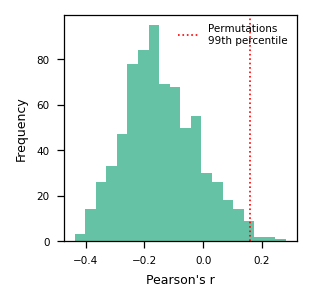

In [51]:
plt.style.use(third_style)
plt.figure()
plt.hist(lgbm_diet_scores, bins=20, color=palette[0])
# plt.hist(pred_baseline_scores, bins=20, color=palette[1], alpha=0.5)
plt.xlabel("Pearson's r")
plt.ylabel("Frequency")
plt.axvline(percentile_99, color='red', linestyle='dotted', linewidth=0.8, label="Permutations\n99th percentile")
# plt.title('Distribution of Correlation Values Across All Species', fontsize=12)
plt.legend()
# plt.savefig(<file_name>.png, dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
# plt.savefig(<file_name>.pdf, dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf')
plt.show()